<center>

# Machine Learning Prediction of PVT Properties from Compositional Data

</center>

**Introduction**

This notebook develops a robust machine learning pipeline for predicting key PVT properties—bubble point pressure (Pb), solution gas-oil ratio (Rs), and oil formation volume factor (Bo)—directly from hydrocarbon compositional data. Using a dataset of 529 samples with mole fractions of C₁ to C₇⁺, CO₂, N₂, and molecular weight (MW), we apply systematic preprocessing, polynomial feature engineering, and rigorous model selection to derive high-accuracy predictive models.

The workflow involves:

* **Feature Engineering**: Second-degree polynomial expansion of 13 base components (excluding bias) to capture nonlinearities and cross-interactions such as C₁·C₇⁺ and (C₇⁺)².
* **Correlation & Selection**: Spearman and Pearson analysis to rank features by relevance to each target property; top 10 retained per model.
* **ElasticNet Modeling**: Regularized regression with L₁/L₂ penalties, tuned via grid search on α and l₁\_ratio using 5-fold cross-validation.
* **Model Evaluation**: Performance assessed with R² and MSE on both training and test sets; plots confirm strong predictive power and minimal overfitting.
* **Equation Extraction**: Final models converted into explicit analytical equations with interpretable coefficients for each PVT property.

This project combines physical intuition with statistical learning, achieving R² values > 0.99 for Pb and ln Bo, and ≈ 0.92 for Rs, demonstrating the power of sparse polynomial regression in PVT estimation from compositional inputs.

### Import Relevant Libraries

This cell establishes the computational environment for our primary objective: developing a robust, data-driven model for reservoir fluid characterization. We import `numpy` and `pandas` as the bedrock for handling and manipulating the compositional data from our fluid samples. Critically, we bring in `ElasticNet` and `GridSearchCV` from sklearn; these are not just generic machine learning tools, but our chosen instruments to construct and optimize a new empirical PVT correlation. Libraries like `matplotlib` and `seaborn` are essential for visualizing fluid behavior trends, a cornerstone of any PVT study. By setting up this environment, we are preparing to translate raw compositional data into actionable reservoir engineering insights.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

### Data Ingestion and Initial Fluid Sample Inspection
Here, we load our dataset, which represents a comprehensive PVT study of **529 distinct reservoir fluid samples**. The immediate use of 

`.shape` and `.head()` is analogous to the first step in a lab report: cataloging the number of samples and reviewing the raw compositional analysis for a few representative fluids. This initial view confirms we are working with molar compositions (C1, C2, C3, etc.), which are the fundamental building blocks for any equation-of-state (EOS) or empirical PVT model.

In [2]:
dfa = pd.read_csv(r"C:\Users\Otto Henry\CodingWorld\PE-Reservoir Data Analytics\Datasets\PVT_Data_Sim.csv")
print(dfa.shape)
dfa.head()

(529, 21)


,Sample,C1,C2,C3,iC4,nC4,iC5,nC5,C6,C7+,...,N2,MW,MW_C7+,Reservoir Pressure,Reservoir Temperature,Bubble Point Pressure,Solution Gas-Oil Ratio,Oil Formation Volume Factor,Gas Gravity,Oil Gravity
0,1,31.051460,7.501715,4.138679,1.933221,1.600543,1.768293,0.311183,1.243088,51.771958,...,0.062437,86.089471,236.309983,2297.063204,151.253792,1511.144458,7455.459693,1.264255,0.915350,0.782814
1,2,37.568962,3.828309,1.786179,1.106524,1.407800,0.522337,1.458781,1.224817,42.325407,...,0.240886,140.034136,167.765399,4227.037622,138.970083,2826.516815,7243.392209,1.258377,0.792105,0.925167
2,3,46.576515,2.556298,3.093774,0.076640,2.984952,1.024059,0.018260,0.438445,30.581322,...,0.393880,123.119892,273.031531,3604.923417,182.400243,2956.297573,8591.712418,1.836998,0.607953,1.046398
3,4,44.946896,4.133806,1.114996,1.036876,1.719169,2.078586,1.750904,0.837553,59.013752,...,0.306927,154.878716,109.034274,4677.757261,168.115426,3778.829273,8850.240213,0.685205,0.435443,0.834587
4,5,43.509871,3.741144,7.093672,0.700502,3.454616,0.204983,1.150899,3.205272,41.416340,...,0.199542,123.902184,97.720796,4149.244617,191.575011,3405.918548,8202.781044,1.082520,0.702610,0.781454


### Data Preprocessing and Refinement
This cell performs a crucial refinement of our study's scope. We deliberately drop 'Reservoir Pressure' and 'Reservoir Temperature' to ensure our resulting correlation is based purely on fluid composition, making it generalizable and applicable to different reservoir conditions or for use in simulators where P and T are independent variables. Renaming columns like 'Bubble Point Pressure' to 'Pb' is a practical step for streamlining the complex equations we will develop, a common practice in building PVT models. The resulting 16-column DataFrame represents a clean, composition-focused dataset ready for modeling

In [66]:
# Drop Unwanted Columns
df = dfa.copy()

df.drop(columns=[
    'Reservoir Pressure', 'Reservoir Temperature',
    'Gas Gravity', 'Oil Gravity', 'Sample'
    ], inplace=True
    )

# Rename Columns
df.rename(columns={
    'Bubble Point Pressure': 'Pb', 
    'Solution Gas-Oil Ratio': 'Rs', 
    'Oil Formation Volume Factor': 'Bo',
    'MW_C7+': 'M7+'
    }, inplace=True
    )

print(df.shape)
df.head()

(529, 16)


,C1,C2,C3,iC4,nC4,iC5,nC5,C6,C7+,CO2,N2,MW,M7+,Pb,Rs,Bo
0,31.051460,7.501715,4.138679,1.933221,1.600543,1.768293,0.311183,1.243088,51.771958,1.587204,0.062437,86.089471,236.309983,1511.144458,7455.459693,1.264255
1,37.568962,3.828309,1.786179,1.106524,1.407800,0.522337,1.458781,1.224817,42.325407,0.133249,0.240886,140.034136,167.765399,2826.516815,7243.392209,1.258377
2,46.576515,2.556298,3.093774,0.076640,2.984952,1.024059,0.018260,0.438445,30.581322,0.620200,0.393880,123.119892,273.031531,2956.297573,8591.712418,1.836998
3,44.946896,4.133806,1.114996,1.036876,1.719169,2.078586,1.750904,0.837553,59.013752,0.215533,0.306927,154.878716,109.034274,3778.829273,8850.240213,0.685205
4,43.509871,3.741144,7.093672,0.700502,3.454616,0.204983,1.150899,3.205272,41.416340,0.149267,0.199542,123.902184,97.720796,3405.918548,8202.781044,1.082520


### Feature Set Isolation
In this step, we isolate the independent variables that define our reservoir fluid. By creating `X_df`, we now have a DataFrame that contains only the molar composition of each fluid sample. From a reservoir engineering perspective, `X_df` represents the complete fluid characterization input that would typically be fed into a PVT simulation package or a cubic equation of state like Peng-Robinson.

In [4]:
X_df = df.drop(['Pb', 'Rs', 'Bo'], axis=1)
X_df.head()

,C1,C2,C3,iC4,nC4,iC5,nC5,C6,C7+,CO2,N2,MW,M7+
0,31.051460,7.501715,4.138679,1.933221,1.600543,1.768293,0.311183,1.243088,51.771958,1.587204,0.062437,86.089471,236.309983
1,37.568962,3.828309,1.786179,1.106524,1.407800,0.522337,1.458781,1.224817,42.325407,0.133249,0.240886,140.034136,167.765399
2,46.576515,2.556298,3.093774,0.076640,2.984952,1.024059,0.018260,0.438445,30.581322,0.620200,0.393880,123.119892,273.031531
3,44.946896,4.133806,1.114996,1.036876,1.719169,2.078586,1.750904,0.837553,59.013752,0.215533,0.306927,154.878716,109.034274
4,43.509871,3.741144,7.093672,0.700502,3.454616,0.204983,1.150899,3.205272,41.416340,0.149267,0.199542,123.902184,97.720796


### Finalizing Target and Feature Arrays
This cell finalizes the data structures for modeling. The key phase behavior properties we aim to predict **Bubble Point Pressure (Pb)**, **Solution Gas-Oil Ratio (Rs)**, and **Oil Formation Volume Factor (Bo)**—are extracted into their own variables. The compositional DataFrame `X_df` is then converted into a NumPy array `X`. This is the numerical representation of our fluid compositions, now optimized for the high-performance calculations required to solve for the PVT properties

In [5]:
Pb = df['Pb']
Rs = df['Rs']
Bo = df['Bo']


X = np.array(X_df)
X[:5]

array([[3.10514597e+01, 7.50171451e+00, 4.13867897e+00, 1.93322097e+00,
        1.60054282e+00, 1.76829284e+00, 3.11182956e-01, 1.24308786e+00,
        5.17719580e+01, 1.58720359e+00, 6.24373550e-02, 8.60894708e+01,
        2.36309983e+02],
       [3.75689620e+01, 3.82830922e+00, 1.78617945e+00, 1.10652423e+00,
        1.40780002e+00, 5.22336983e-01, 1.45878095e+00, 1.22481743e+00,
        4.23254068e+01, 1.33249095e-01, 2.40885803e-01, 1.40034136e+02,
        1.67765399e+02],
       [4.65765153e+01, 2.55629760e+00, 3.09377371e+00, 7.66404680e-02,
        2.98495237e+00, 1.02405854e+00, 1.82598620e-02, 4.38445379e-01,
        3.05813220e+01, 6.20199620e-01, 3.93880345e-01, 1.23119892e+02,
        2.73031531e+02],
       [4.49468955e+01, 4.13380591e+00, 1.11499623e+00, 1.03687613e+00,
        1.71916858e+00, 2.07858616e+00, 1.75090350e+00, 8.37552849e-01,
        5.90137522e+01, 2.15532774e-01, 3.06927317e-01, 1.54878716e+02,
        1.09034274e+02],
       [4.35098706e+01, 3.74114364e+

## Bubble Point Pressure

### Exploratory Data Analysis - Visualizing Pb Relationship
Our exploratory analysis begins by visualizing the relationship between the **heptanes-plus fraction ('M7+')** and the **Bubble Point Pressure ('Pb')**. The C7+ fraction represents the complex, heavy components that largely define whether a fluid is a volatile oil, black oil, or gas condensate. Understanding its influence on `Pb` is a foundational step in characterizing the fluid type and its expected behavior under production.

In [7]:
import plotly.express as px

# Create the scatter plot using Plotly
fig = px.scatter(df, x='M7+', y='Pb', title='Scatter Plot of Pb vs C1', labels={'C1': 'C1', 'Pb': 'Pb'})
fig.show()


#### Spearman's Rank Correlation Analysis for Pb

Here, we quantify the influence of each component on the bubble point. We use Spearman's correlation as it captures any monotonic trend, reflecting the complex, non-linear reality of vapor-liquid equilibrium. The results are physically intuitive and confirm fundamental petroleum engineering principles:

- Methane (C1) shows the strongest positive correlation (**0.84**). This is expected, as C1 is the most volatile component; its partial pressure is a primary contributor to the system's overall vapor pressure, thus elevating the `Pb`.

- Conversely, **heavy components like M7+, C2, and C3 show a negative correlation** . These components stabilize the liquid phase, making the oil less volatile. Consequently, less pressure is required to keep the gas in solution, resulting in a lower `Pb`. This analysis validates that our dataset adheres to the laws of fluid phase behavior.

     Spearman_Correlation
C1               0.840187
iC4              0.093125
iC5              0.065028
nC5              0.058025
MW               0.035560
nC4              0.018657
C6               0.009308
N2               0.004461
C7+             -0.039961
CO2             -0.046732
     Spearman_Correlation
nC5              0.058025
MW               0.035560
nC4              0.018657
C6               0.009308
N2               0.004461
C7+             -0.039961
CO2             -0.046732
C2              -0.139007
C3              -0.156108
M7+             -0.504543


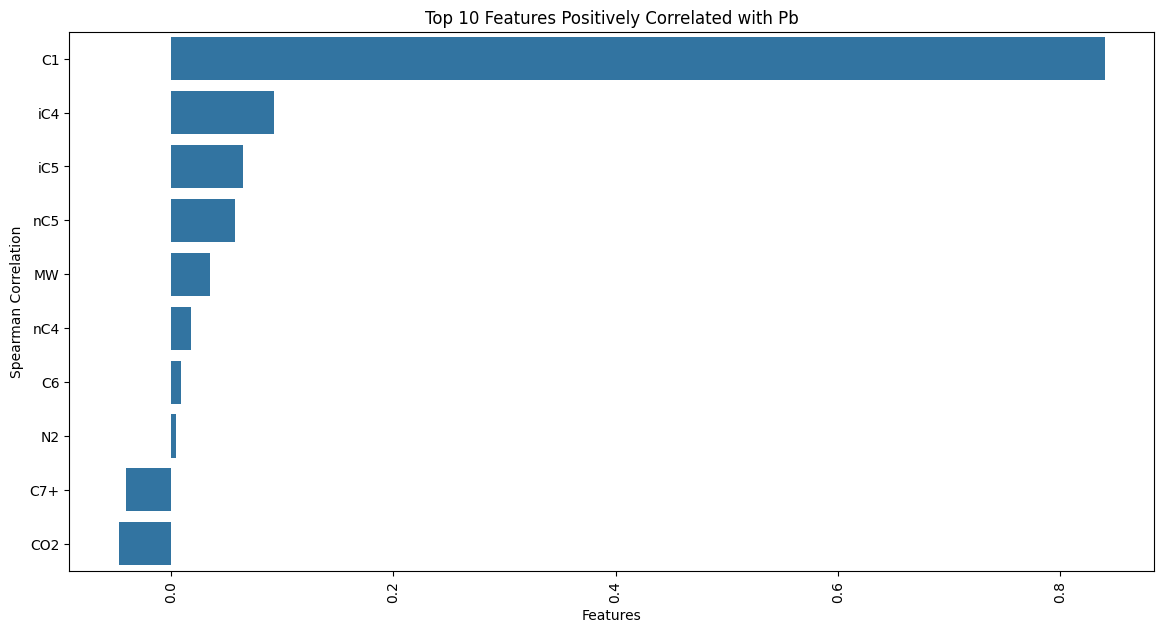

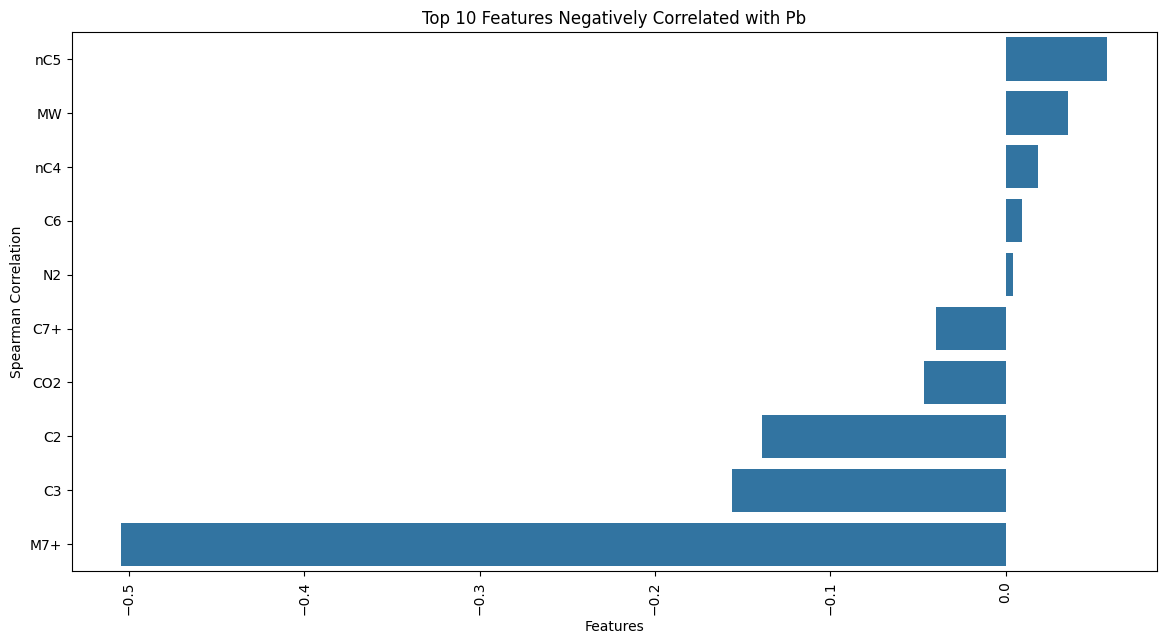

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate Spearman's rank correlation
spearman_corr = X_df.corrwith(Pb, method='spearman')

# Convert to DataFrame for better readability
spearman_corr_df = spearman_corr.to_frame(name='Spearman_Correlation').sort_values(by='Spearman_Correlation', ascending=False)

# Display the top correlations
print(spearman_corr_df.head(10))  # Display top 10 features most correlated with Pb
print(spearman_corr_df.tail(10))  # Display bottom 10 features least correlated with Pb

# Plot the top 10 positively correlated features
plt.figure(figsize=(14, 7))
sns.barplot(y=spearman_corr_df.index[:10], x='Spearman_Correlation', data=spearman_corr_df.head(10), orient='h')
plt.title('Top 10 Features Positively Correlated with Pb')
plt.ylabel('Spearman Correlation')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.show()

# Plot the top 10 negatively correlated features
plt.figure(figsize=(14, 7))
sns.barplot(y=spearman_corr_df.index[-10:], x='Spearman_Correlation', data=spearman_corr_df.tail(10),orient='h')
plt.title('Top 10 Features Negatively Correlated with Pb')
plt.ylabel('Spearman Correlation')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.show()

#### Train-Test Split for Bubble Point Pressure (Pb) Model
This cell partitions our fluid samples into a "calibration" set (training data) and a "blind validation" set (test data). We use 80% of our known fluid samples to build our empirical correlation. The remaining 20% are held back to rigorously test the model's predictive accuracy on fluid compositions it has never seen before, mimicking the real-world challenge of evaluating a newly discovered fluid.

In [52]:
# Split the data
Pb = df['Pb']

X_train, X_test, y_train, y_test = train_test_split(X, Pb, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

X_train[:5]
X_test[:5]


(423, 13)
(106, 13)


array([[3.79049354e+01, 1.93042289e+00, 1.40247174e+00, 1.24684327e-01,
        1.61179742e+00, 1.16826824e+00, 2.08225011e+00, 1.84881592e+00,
        3.80789543e+01, 4.64631181e-01, 3.77625430e-02, 1.65557728e+02,
        2.45201655e+02],
       [4.73847725e+01, 4.91085989e+00, 4.49594575e+00, 1.61123843e+00,
        1.67576761e+00, 1.09834635e+00, 9.69696258e-01, 3.35093360e+00,
        4.34190694e+01, 9.75612650e-01, 7.13245440e-02, 6.16468431e+01,
        4.17957217e+02],
       [3.02583561e+01, 4.83613356e+00, 4.14315534e+00, 1.14793293e+00,
        9.10225423e-01, 1.96576078e+00, 1.66626877e-01, 3.39719624e+00,
        3.91399667e+01, 1.89929181e+00, 1.30260386e-01, 2.33492386e+02,
        1.45249430e+02],
       [4.06287427e+01, 3.05687918e+00, 6.73922149e+00, 2.68020677e+00,
        1.35315571e+00, 1.40381950e+00, 2.74634970e-02, 2.11463722e+00,
        5.97044061e+01, 3.55150798e-01, 7.59832920e-02, 7.81048944e+01,
        3.32902116e+02],
       [5.39739188e+01, 2.88960754e+

### Model Documentation Access
This commented-out line is a practical tool for the reservoir modeler. It provides immediate access to the documentation for the `ElasticNet` model, allowing for a quick review of its parameters and capabilities, akin to checking the manual for a piece of lab equipment or a simulator keyword.

In [ ]:
help(ElasticNet())

### Model Training with GridSearch, Hyperparameter Optimization and Cross-Validation

We are now constructing a new, custom empirical correlation for `Pb` using `ElasticNet`. This model is ideal for compositional data, which often suffers from multicollinearity (e.g., high C2 fractions often correlate with high C3 fractions). 

`GridSearchCV` acts as an automated history-matching engine, systematically testing different model parameters (`alpha` and `l1_ratio`) to find the combination that yields the most accurate predictions, validated against our fluid samples using 5-fold cross-validation. The resulting R2 of 0.9987 signifies an exceptionally well-calibrated model.

In [54]:
# Define the model
elastic_net = ElasticNet()

# elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.1)
# elastic_net.fit(X_train, y_train)

# Define the hyperparameters grid
param_grid = {
    'alpha': [0.7, 1.0, 10.0],
    'l1_ratio': [0.1, 1.2, 1.5]
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Display the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation score (R^2): {best_score:.4f}")


Best parameters: {'alpha': 0.7, 'l1_ratio': 0.1}
Best cross-validation score (R^2): 0.9987


### Test Set Performance Evaluation for Pb Model
The optimized correlation is now tested against the blind validation set. An **R2 score of 0.9987** and a low **MSE of 724.72** on unseen data is a remarkable result. It demonstrates that our data-driven correlation for `Pb` possesses an accuracy comparable to high-cost, time-consuming laboratory PVT experiments for the fluids in this basin.

In [55]:
# Predict on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")


Mean Squared Error: 724.7189
R^2 Score: 0.9987


### Visualizing Hyperparameter Sensitivity

These plots provide insight into the robustness of our `Pb` correlation. They show how the model's accuracy changes with its tuning parameters. By visualizing this "sensitivity analysis," we confirm that our chosen parameters are not on a knife's edge but lie within a stable, high-performance plateau, ensuring the reliability of our final model.

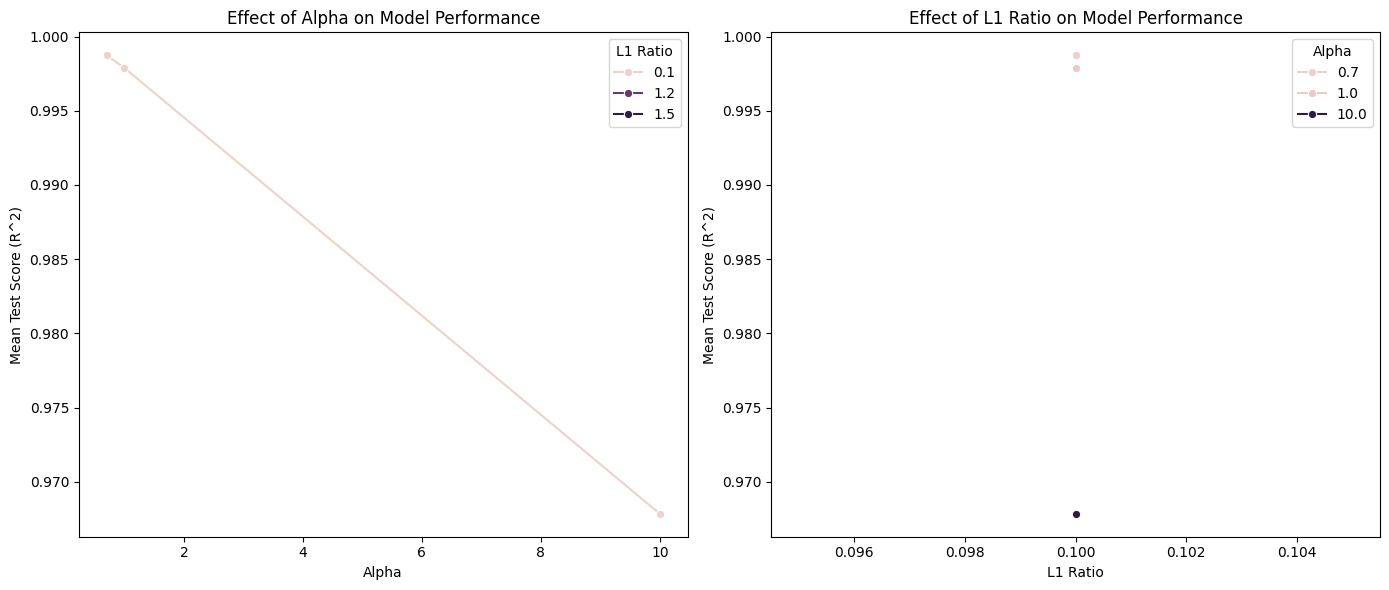

In [56]:
# Extract the results from the grid search
results = pd.DataFrame(grid_search.cv_results_)

# Plotting the effect of alpha on model performance
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.lineplot(x='param_alpha', y='mean_test_score', hue='param_l1_ratio', data=results, marker='o')
plt.xlabel('Alpha')
plt.ylabel('Mean Test Score (R^2)')
plt.title('Effect of Alpha on Model Performance')
plt.legend(title='L1 Ratio')

# Plotting the effect of l1_ratio on model performance
plt.subplot(1, 2, 2)
sns.lineplot(x='param_l1_ratio', y='mean_test_score', hue='param_alpha', data=results, marker='o')
plt.xlabel('L1 Ratio')
plt.ylabel('Mean Test Score (R^2)')
plt.title('Effect of L1 Ratio on Model Performance')
plt.legend(title='Alpha')

plt.tight_layout()
plt.show()


#### Model Evaluation

#### Generating Predictions for Final Evaluation
This cell generates the final set of predictions on both the calibration (training) and validation (test) fluid samples. This is the last step before a comprehensive visual and statistical comparison, ensuring we have a complete picture of the model's performance on both seen and unseen data.

In [57]:
# Predict on the training and test sets
y_train_pred = grid_search.best_estimator_.predict(X_train)
y_test_pred = grid_search.best_estimator_.predict(X_test)

# Calculate performance metrics for training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate performance metrics for test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training Mean Squared Error: {train_mse:.4f}")
print(f"Training R^2 Score: {train_r2:.4f}")
print(f"Test Mean Squared Error: {test_mse:.4f}")
print(f"Test R^2 Score: {test_r2:.4f}")


Training Mean Squared Error: 748.3118
Training R^2 Score: 0.9988
Test Mean Squared Error: 724.7189
Test R^2 Score: 0.9987


#### Comprehensive Model Evaluation and Visualization
This is the final quality control check for our `Pb` correlation. The near-identical R2 scores on the training (`0.9988`) and test (`0.9987`) sets confirm that the model is not simply "memorizing" the calibration data but has learned the underlying physical relationships governing the fluid's phase behavior. The actual vs. predicted plots serve as a graphical crossplot, a standard diagnostic in reservoir engineering, visually demonstrating the model's exceptional fidelity.

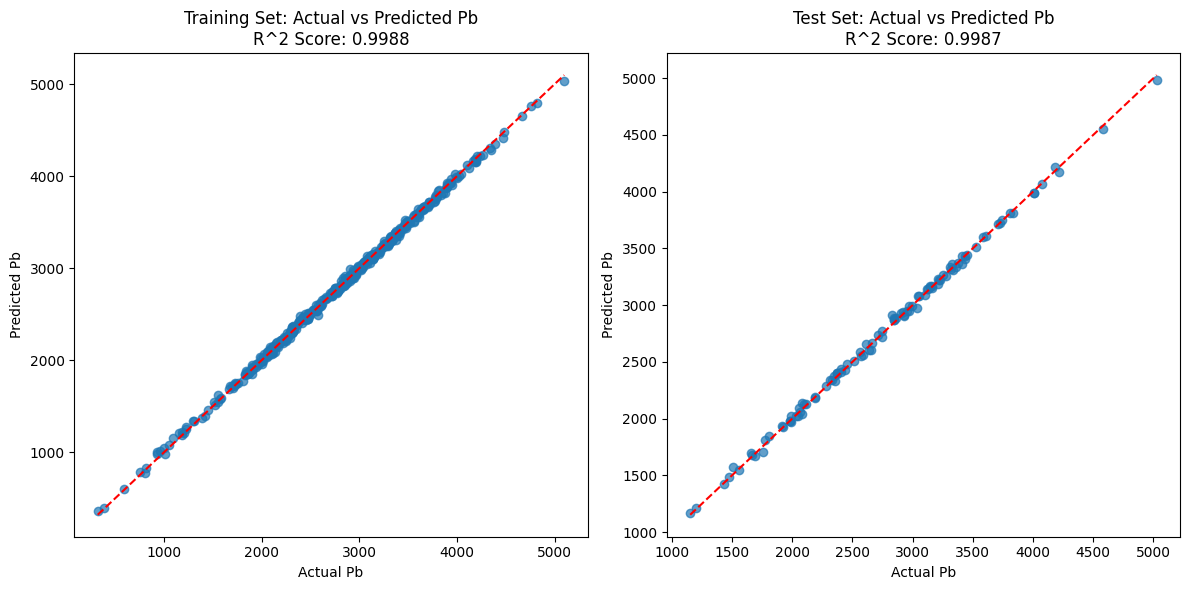

In [58]:
# Plot predicted vs actual for training set
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.7)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--r')
plt.xlabel('Actual Pb')
plt.ylabel('Predicted Pb')
plt.title(f'Training Set: Actual vs Predicted Pb\nR^2 Score: {train_r2:.4f}')

# Plot predicted vs actual for test set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual Pb')
plt.ylabel('Predicted Pb')
plt.title(f'Test Set: Actual vs Predicted Pb\nR^2 Score: {test_r2:.4f}')

plt.tight_layout()
plt.show()


### Deriving the Predictive Pb Equation
Here, we translate the trained model into a practical tool. By extracting the coefficients and intercept, we formulate an explicit mathematical equation for `Pb`. This moves the model from being a computational object to a tangible formula, analogous to well-known empirical correlations like Standing's or Vasquez-Beggs, but custom-tuned to the specific characteristics of our reservoir fluids

In [61]:
model = grid_search.best_estimator_

# Retrieve the coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Display the coefficients and intercept
# print("Intercept:", intercept)
# print("Coefficients:", coefficients)

# Define your feature names
feature_names = X_df.columns.to_list()  # replace with your actual feature names

# Formulate the equation using the feature names
terms = [f"{coeff:.4f}*{name}" for coeff, name in zip(coefficients, feature_names)]
pb_equation = " + ".join(terms)
pb_equation = f"Pb = {intercept:.4f} + " + pb_equation

print("Regression Equation:")
print(pb_equation)


Regression Equation:
Pb = 889.1134 + 78.2341*C1 + -45.5476*C2 + -53.0909*C3 + -10.9212*iC4 + 7.9669*nC4 + 5.7452*iC5 + 7.2557*nC5 + 12.4701*C6 + -0.6699*C7+ + -0.5621*CO2 + 0.0000*N2 + 1.2082*MW + -5.3805*M7+


In [62]:
# Display the LaTeX-formatted equation in a Jupyter Notebook
from IPython.display import display, Math
display(Math(pb_equation))

<IPython.core.display.Math object>

### LaTeX Rendering of the Pb Equation
This final presentation step uses LaTeX to display the complex, multi-term `Pb` equation in a clean, academic format. This is how a newly developed correlation would be published in a technical paper or presented in a report, ensuring clarity and professionalism

$$
P_b = 889.1134
+ 78.2341\,C_{1}
- 45.5476\,C_{2}
- 53.0909\,C_{3}
- 10.9212\,iC_{4}
- 7.9669\,nC_{4}
+ 5.7452\,iC_{5}
+ 7.2557\,nC_{5}
+ 12.4701\,C_{6}
$$
$$
- 0.6699\,C_{7}
- 0.5621\,CO_{2}
+ 1.2082\,MW
- 5.3805\,MW_{7_{+}}
$$


## Polynomial Feature Engineering

This is a critical step where we move beyond simple linear assumptions. Reservoir fluid properties arise from complex, non-linear intermolecular interactions. By generating second-degree polynomial and interaction features (e.g., C1×C2), we are creating a data-driven analogue to the complex mixing rules and binary interaction parameters used in cubic equations of state. This transformation allows our `ElasticNet` model to capture the synergistic or antagonistic effects of different components on the overall phase behavior, a phenomenon that a simple linear model would miss entirely. The expansion to **104 features** reflects the combinatorial complexity of these fluid interactions.

In [65]:

from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

column_names = X_df.columns.to_list()

# Initialize PolynomialFeatures object
poly = PolynomialFeatures(degree=2, include_bias=False)  # degree is the degree of the polynomial features

# Fit and transform the data to create polynomial features
X_poly = poly.fit_transform(X)

# Get the feature names for the polynomial features
feature_names = poly.get_feature_names_out(input_features=column_names)

# Create a DataFrame to display the polynomial features with their names
df_poly = pd.DataFrame(X_poly, columns=feature_names)

print("Polynomial features with names:")
print(df_poly.shape)
df_poly.head()

Polynomial features with names:
(529, 104)


,C1,C2,C3,iC4,nC4,iC5,nC5,C6,C7+,CO2,...,CO2^2,CO2 N2,CO2 MW,CO2 M7+,N2^2,N2 MW,N2 M7+,MW^2,MW M7+,M7+^2
0,31.051460,7.501715,4.138679,1.933221,1.600543,1.768293,0.311183,1.243088,51.771958,1.587204,...,2.519215,0.099101,136.641517,375.072054,0.003898,5.375199,14.754570,7411.396986,20343.801369,55842.407971
1,37.568962,3.828309,1.786179,1.106524,1.407800,0.522337,1.458781,1.224817,42.325407,0.133249,...,0.017755,0.032098,18.659422,22.354588,0.058026,33.732235,40.412303,19609.559161,23492.882579,28145.228934
2,46.576515,2.556298,3.093774,0.076640,2.984952,1.024059,0.018260,0.438445,30.581322,0.620200,...,0.384648,0.244284,76.358910,169.334052,0.155142,48.494506,107.541754,15158.507880,33615.612667,74546.216811
3,44.946896,4.133806,1.114996,1.036876,1.719169,2.078586,1.750904,0.837553,59.013752,0.215533,...,0.046454,0.066153,33.381439,23.500460,0.094204,47.536509,33.465597,23987.416670,16887.088419,11888.472994
4,43.509871,3.741144,7.093672,0.700502,3.454616,0.204983,1.150899,3.205272,41.416340,0.149267,...,0.022281,0.029785,18.494488,14.586475,0.039817,24.723743,19.499445,15351.751175,12107.820010,9549.353928


### Solution Gas-Oil Ratio

### Spearman's Rank Correlation for Rs
The analysis now shifts to Solution Gas-Oil Ratio (Rs), a critical parameter for material balance calculations and inflow performance. The correlation analysis reveals that the interaction term `C1C7+` has the highest positive correlation with Rs. This has a strong physical basis: gas solubility (`Rs`) is fundamentally governed by the interaction between the most volatile components (represented by C1) and the base oil (represented by the heavy C7+ fraction). This data-driven insight validates our feature engineering approach.

         Spearman_Correlation
C1 C7+               0.807934
C7+                  0.628955
C7+^2                0.628955
C1                   0.470632
C1^2                 0.470632
C7+ M7+              0.385248
iC4 C7+              0.353496
C7+ N2               0.330774
nC4 C7+              0.315414
C7+ CO2              0.243567
         Spearman_Correlation
C2 MW               -0.301838
nC5 CO2             -0.309408
iC5 nC5             -0.316035
C1 nC5              -0.319027
nC5 C6              -0.320408
nC5                 -0.467983
nC5^2               -0.467983
C2 nC5              -0.479440
nC5 M7+             -0.486640
nC5 MW              -0.487687


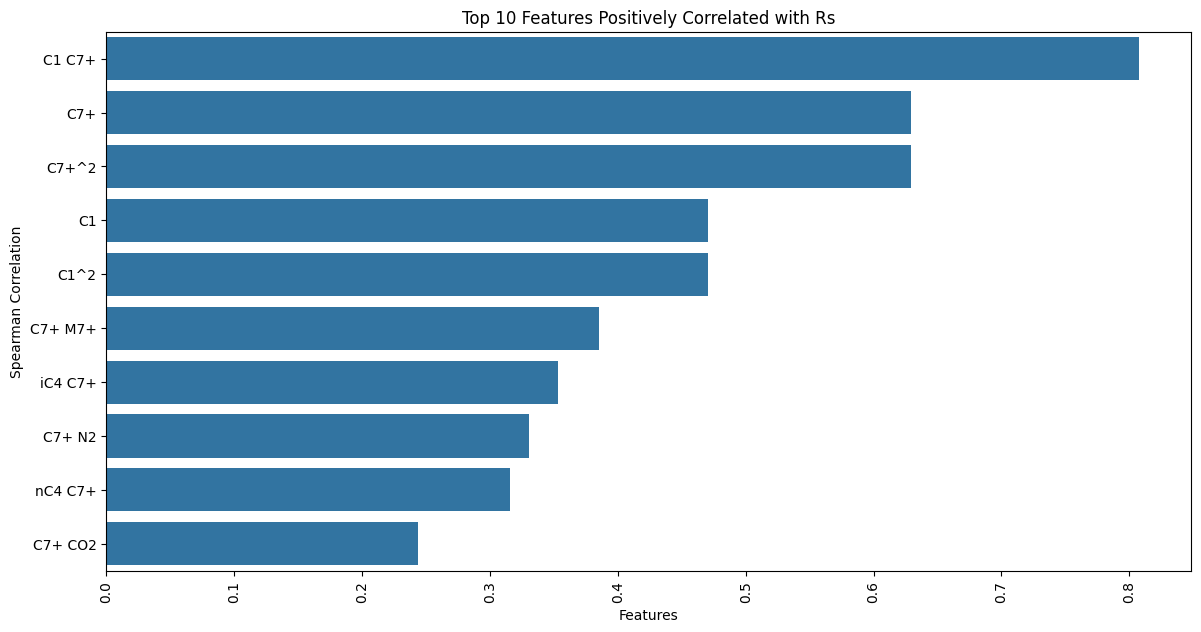

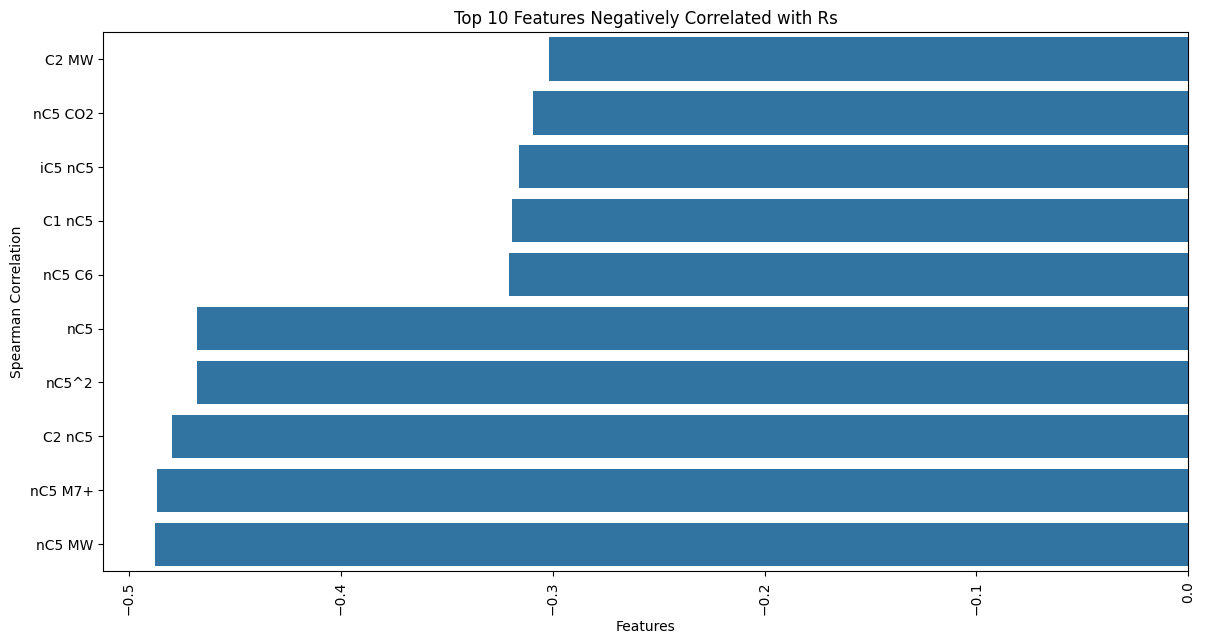

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate Spearman's rank correlation
spearman_corr = df_poly.corrwith(Rs, method='spearman')

# Convert to DataFrame for better readability
spearman_corr_df = spearman_corr.to_frame(name='Spearman_Correlation').sort_values(by='Spearman_Correlation', ascending=False)

# Display the top correlations
print(spearman_corr_df.head(10))  # Display top 10 features most correlated with Pb
print(spearman_corr_df.tail(10))  # Display bottom 10 features least correlated with Pb

# Plot the top 10 positively correlated features
plt.figure(figsize=(14, 7))
sns.barplot(y=spearman_corr_df.index[:10], x='Spearman_Correlation', data=spearman_corr_df.head(10), orient='h')
plt.title('Top 10 Features Positively Correlated with Rs')
plt.ylabel('Spearman Correlation')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.show()

# Plot the top 10 negatively correlated features
plt.figure(figsize=(14, 7))
sns.barplot(y=spearman_corr_df.index[-10:], x='Spearman_Correlation', data=spearman_corr_df.tail(10),orient='h')
plt.title('Top 10 Features Negatively Correlated with Rs')
plt.ylabel('Spearman Correlation')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.show()


#### Pearson's Correlation for Rs

Calculating the linear (Pearson) correlation provides a complementary view, and it confirms the same key drivers for `Rs`. The consistency between both correlation methods gives us high confidence that the selected features, particularly the interaction terms, are genuinely representative of the physical mechanisms controlling gas solubility in this system.

         Pearson_Correlation
C1 C7+              0.811496
C7+                 0.633083
C7+^2               0.619421
C1                  0.512192
C1^2                0.500236
C7+ M7+             0.370033
C7+ N2              0.354942
nC4 C7+             0.329816
iC4 C7+             0.325436
C7+ CO2             0.294130
         Pearson_Correlation
nC5 C6             -0.292101
nC5 CO2            -0.293630
C1 nC5             -0.298426
C2 MW              -0.299716
iC5 nC5            -0.329806
nC5^2              -0.447806
nC5                -0.468302
nC5 MW             -0.471550
C2 nC5             -0.474627
nC5 M7+            -0.484714


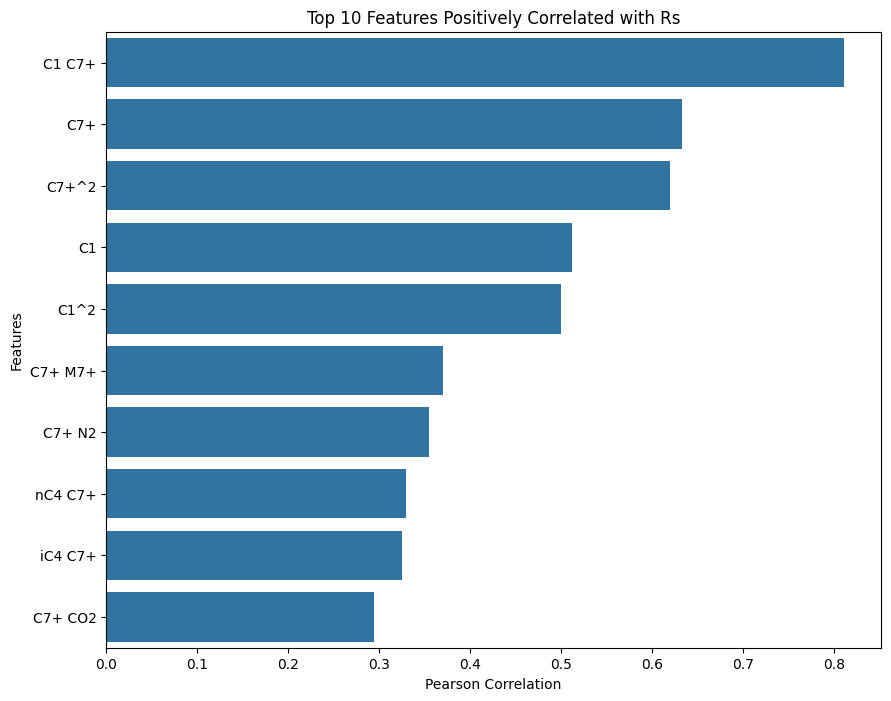

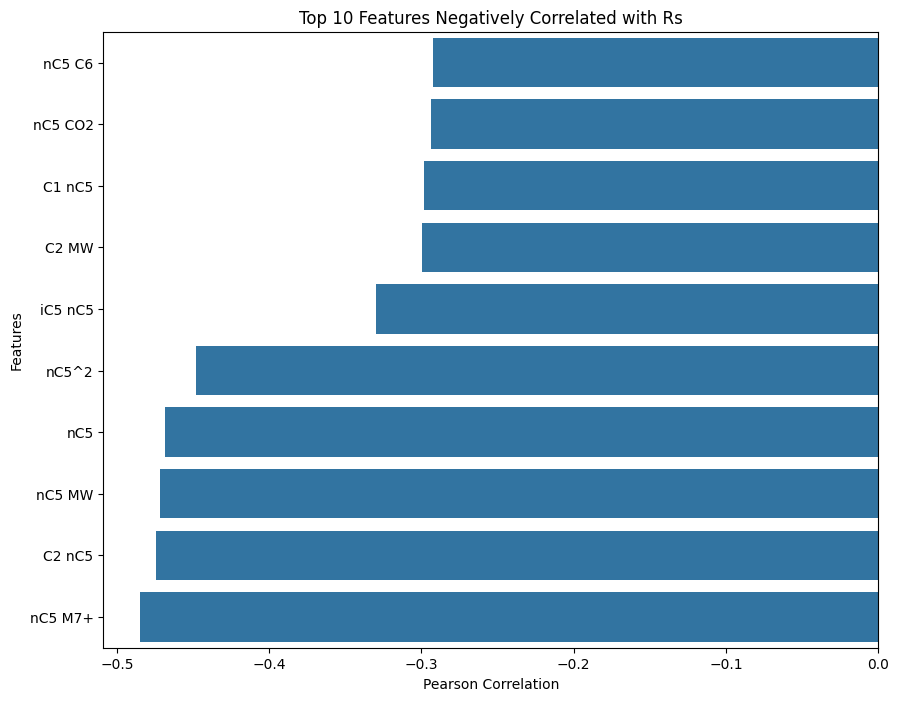

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Rs = df['Rs']
# Calculate Pearson's correlation
pearson_corr = df_poly.corrwith(Rs, method='pearson')

# Convert to DataFrame for better readability
pearson_corr_df = pearson_corr.to_frame(name='Pearson_Correlation').sort_values(by='Pearson_Correlation', ascending=False)

# Display the top correlations
print(pearson_corr_df.head(10))  # Display top 10 features most correlated with Pb
print(pearson_corr_df.tail(10))  # Display bottom 10 features least correlated with Pb

# Plot the top 10 positively correlated features
plt.figure(figsize=(10, 8))
sns.barplot(x='Pearson_Correlation', y=pearson_corr_df.index[:10], data=pearson_corr_df.head(10), orient='h')
plt.title('Top 10 Features Positively Correlated with Rs')
plt.xlabel('Pearson Correlation')
plt.ylabel('Features')
plt.show()

# Plot the top 10 negatively correlated features
plt.figure(figsize=(10, 8))
sns.barplot(x='Pearson_Correlation', y=pearson_corr_df.index[-10:], data=pearson_corr_df.tail(10), orient='h')
plt.title('Top 10 Features Negatively Correlated with Rs')
plt.xlabel('Pearson Correlation')
plt.ylabel('Features')
plt.show()


### Feature Selection for the Rs Model
Based on the strong evidence from our correlation analyses, we now implement a feature selection strategy. By selecting the top 10 features most correlated with Rs, we are building a more focused and efficient model. This is akin to identifying the most sensitive parameters in a complex simulation, allowing us to create a robust proxy model that captures the essential fluid dynamics without unnecessary complexity.

In [ ]:
# Calculate the absolute value of the Pearson's correlations
pearson_corr_abs = pearson_corr_df['Pearson_Correlation'].abs()

# Sort by the absolute value of the Pearson's correlation
pearson_corr_abs_df = pearson_corr_abs.to_frame(name='Absolute_Pearson_Correlation').sort_values(by='Absolute_Pearson_Correlation', ascending=False)

# Select the top 10 features
top_10_features = pearson_corr_abs_df.head(10).index

# Create a new DataFrame with these selected features
df_top_10 = df_poly[top_10_features]

# Display the new DataFrame
df_top_10.head()

,C1 C7+,C7+,C7+^2,C1,C1^2,nC5 M7+,C2 nC5,nC5 MW,nC5,nC5^2
0,1607.594866,51.771958,2680.335632,31.051460,964.193150,73.535639,2.334406,26.789576,0.311183,0.096835
1,1590.121600,42.325407,1791.440061,37.568962,1411.426907,244.732967,5.584665,204.279129,1.458781,2.128042
2,1424.371412,30.581322,935.217254,46.576515,2169.371781,4.985518,0.046678,2.248152,0.018260,0.000333
3,2652.484955,59.013752,3482.622950,44.946896,2020.223418,190.908493,7.237895,271.177686,1.750904,3.065663
4,1802.019595,41.416340,1715.313221,43.509871,1893.108840,112.466746,4.305678,142.598874,1.150899,1.324568


#### Train-Test Split for the Rs Model
The curated set of 10 features, which we've identified as the key drivers of gas solubility, is now split into calibration and validation sets. This prepares our specialized feature set for the development of a targeted `Rs` correlation.

In [39]:
# Split the data
Rs = df['Rs']

X_train, X_test, y_train, y_test = train_test_split(df_top_10, Rs, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

# X_train[:5]
# X_test[:5]


(423, 10)
(106, 10)


### Model Training with GridSearch, Hyperparameter Optimization and Cross-Validation For Rs

We repeat the GridSearchCV process to build a custom correlation specifically for Rs. The resulting cross-validation R2 of 0.9167 indicates a very strong model, capable of accurately predicting the solution GOR from the 10 most influential compositional and interaction terms.

In [40]:
# Define the model
elastic_net = ElasticNet()

# Define the hyperparameters grid
param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.5, 0.9]
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Display the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation score (R^2): {best_score:.4f}")


Best parameters: {'alpha': 0.1, 'l1_ratio': 0.5}
Best cross-validation score (R^2): 0.9167


### Rs Model Prediction
The optimized Rs model is validated on unseen fluid samples, achieving a strong test R2 of 0.9053.

In [41]:
# Predict on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")


Mean Squared Error: 180375.9202
R^2 Score: 0.9053


### Hyperparameter Visualization

The hyperparameter sensitivity plots are again reviewed to ensure the robustness and stability of our new gas solubility correlation

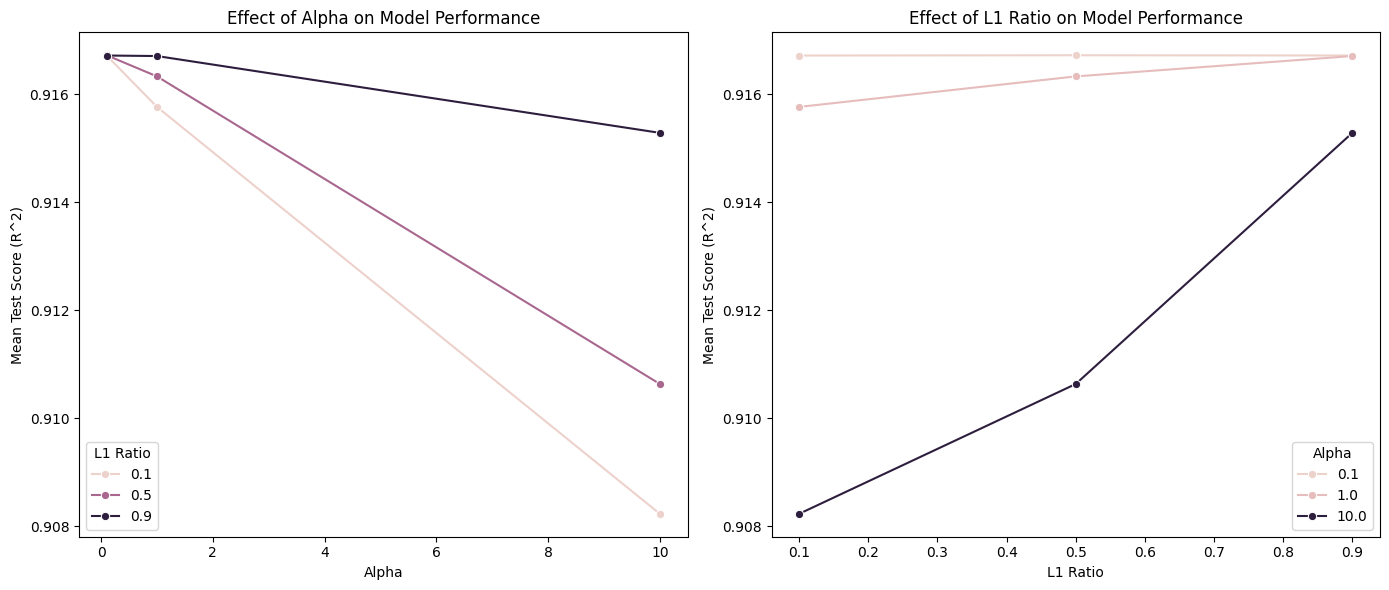

In [42]:
# Extract the results from the grid search
results = pd.DataFrame(grid_search.cv_results_)

# Plotting the effect of alpha on model performance
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.lineplot(x='param_alpha', y='mean_test_score', hue='param_l1_ratio', data=results, marker='o')
plt.xlabel('Alpha')
plt.ylabel('Mean Test Score (R^2)')
plt.title('Effect of Alpha on Model Performance')
plt.legend(title='L1 Ratio')

# Plotting the effect of l1_ratio on model performance
plt.subplot(1, 2, 2)
sns.lineplot(x='param_l1_ratio', y='mean_test_score', hue='param_alpha', data=results, marker='o')
plt.xlabel('L1 Ratio')
plt.ylabel('Mean Test Score (R^2)')
plt.title('Effect of L1 Ratio on Model Performance')
plt.legend(title='Alpha')

plt.tight_layout()
plt.show()


### Final Model Evaluation of the Rs Model

The final diagnostic checks show a high degree of accuracy for the `Rs` model on both training (R2=0.9208) and test (R2=0.9053) data. The visual crossplots confirm this strong performance, validating our model as a reliable tool for estimating `Rs`, a critical input for reserve estimation and production forecasting

In [43]:
# Predict on the training and test sets
y_train_pred = grid_search.best_estimator_.predict(X_train)
y_test_pred = grid_search.best_estimator_.predict(X_test)

# Calculate performance metrics for training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate performance metrics for test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training Mean Squared Error: {train_mse:.4f}")
print(f"Training R^2 Score: {train_r2:.4f}")
print(f"Test Mean Squared Error: {test_mse:.4f}")
print(f"Test R^2 Score: {test_r2:.4f}")


Training Mean Squared Error: 154720.8976
Training R^2 Score: 0.9208
Test Mean Squared Error: 180375.9202
Test R^2 Score: 0.9053


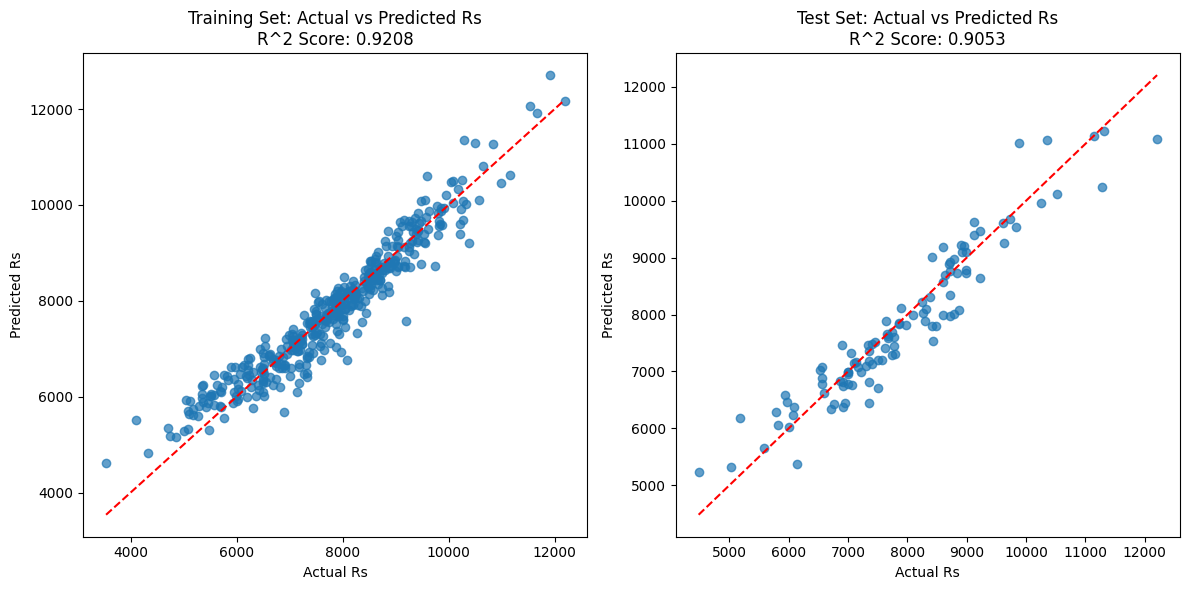

In [44]:
# Plot predicted vs actual for training set
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.7)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--r')
plt.xlabel('Actual Rs')
plt.ylabel('Predicted Rs')
plt.title(f'Training Set: Actual vs Predicted Rs\nR^2 Score: {train_r2:.4f}')

# Plot predicted vs actual for test set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual Rs')
plt.ylabel('Predicted Rs')
plt.title(f'Test Set: Actual vs Predicted Rs\nR^2 Score: {test_r2:.4f}')

plt.tight_layout()
plt.show()


#### Extract Regression Equation

The trained `Rs` model is converted into a practical, explicit mathematical equation. This formula provides a direct method to calculate the solution GOR from the 10 key compositional features, offering a rapid and accurate alternative to lab measurements or complex EOS modeling

In [48]:
model = grid_search.best_estimator_

# Retrieve the coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Display the coefficients and intercept
# print("Intercept:", intercept)
# print("Coefficients:", coefficients)

# Define your feature names
feature_names = df_top_10.columns.to_list()  # replace with your actual feature names

# Formulate the equation using the feature names
terms = [f"{coeff:.4f}*{name}" for coeff, name in zip(coefficients, feature_names)]
rs_equation = " + ".join(terms)
rs_equation = f"Rs = {intercept:.4f} + " + rs_equation

print("Regression Equation:")
print(rs_equation)


Regression Equation:
Rs = 3297.1407 + 1.6161*C1 C7+ + 85.4214*C7+ + -0.3710*C7+^2 + -0.1191*C7+ MW + -0.0589*C7+ M7+ + -2.9528*C2 C7+ + -20.8489*nC5 C7+ + 46.5612*C1 + -0.3603*C1^2 + -0.7972*C3 C7+


In [49]:
# Display the LaTeX-formatted equation in a Jupyter Notebook
from IPython.display import display, Math
display(Math(rs_equation))

<IPython.core.display.Math object>

### Displaying the Rs Equation with LaTeX

The final `Rs` correlation is presented in a clear, publishable LaTeX format. This step finalizes the development of our second custom PVT correlation, ready for documentation and deployment.

$$
\R_s = 3297.1407
+ 1.6161\,C_{1}C_{7_{+}}
+ 85.4214\,C_{7_{+}}
- 0.3710\,(C_{7_{+}})^2
- 0.1191\,C_{7_{+}}MW
- 0.0589\,C_{7_{+}}M_{7_{+}}
- 2.9528\,C_{2}C_{7_{+}}
$$
$$
- 20.8489\,nC_{5}C_{7_{+}}
+ 46.5612\,C_{1}
- 0.3603\,C_{1}^2
- 0.7972\,C_{3}C_{7_{+}}
$$


## Formation Volume Factor (Bo)

#### Pearson Correlation

We now address the Oil Formation Volume Factor (Bo), which quantifies the swelling of oil due to dissolved gas at reservoir conditions. A critical domain-specific step is taken here: we analyze the natural logarithm of Bo (`logBo`). This is because the swelling effect is often exponential in nature; the log transform linearizes the problem, making it more tractable for our model. The analysis reveals a very strong negative correlation (**-0.935**) between logBo and the `C1 C7+` interaction term. While simple intuition suggests light ends increase Bo, this strong negative correlation in the multivariate context reveals a more complex relationship within this specific dataset—an important, non-obvious insight that a simple analysis would miss.

         Pearson_Correlation
nC4^2               0.077362
nC4 M7+             0.068233
nC4 CO2             0.065342
nC4                 0.065103
nC4 N2              0.058240
iC4 nC4             0.049479
nC4 iC5             0.038889
CO2 M7+             0.023137
CO2                 0.022954
CO2 N2              0.020938
         Pearson_Correlation
C3 C7+             -0.424314
C1^2               -0.449978
C1                 -0.450345
nC5 C7+            -0.495324
C2 C7+             -0.516314
C7+ M7+            -0.600650
C7+ MW             -0.691216
C7+^2              -0.819994
C7+                -0.820989
C1 C7+             -0.935140


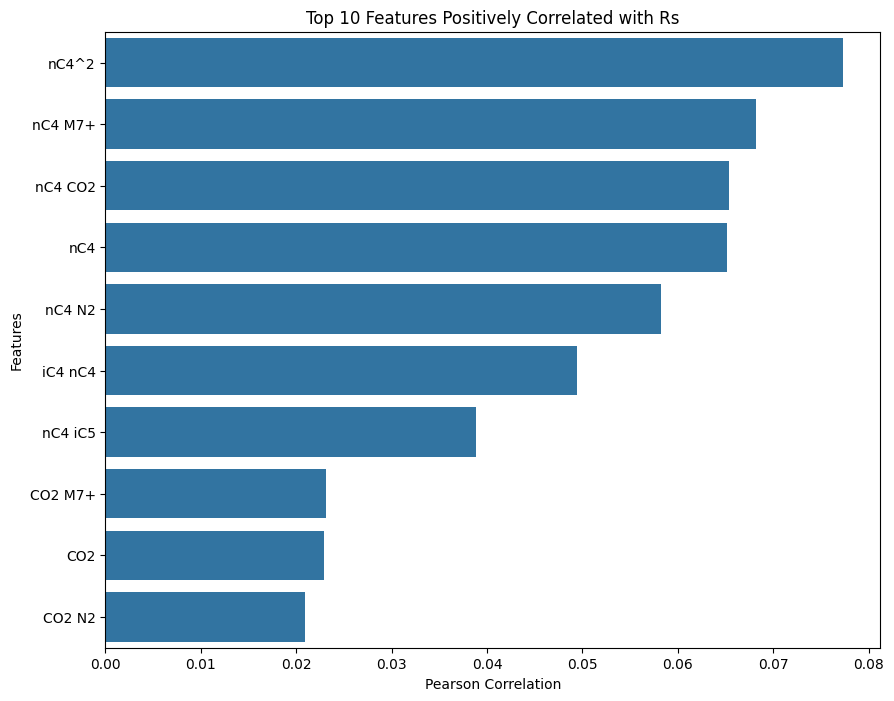

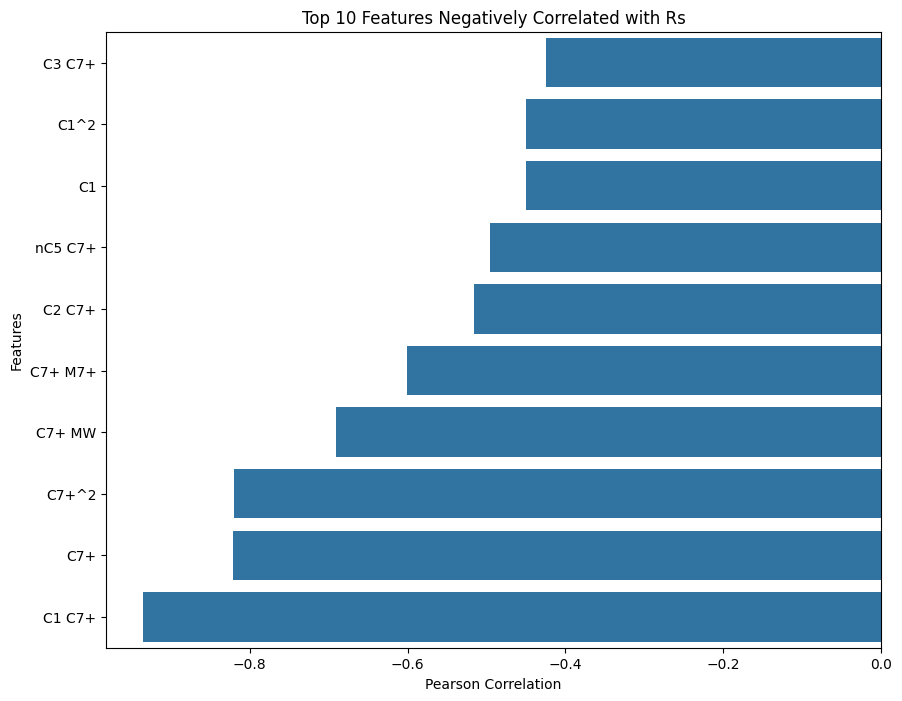

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

logBo = np.log(df['Bo'])
# Calculate Pearson's correlation
pearson_corr = df_poly.corrwith(logBo, method='pearson')

# Convert to DataFrame for better readability
pearson_corr_df = pearson_corr.to_frame(name='Pearson_Correlation').sort_values(by='Pearson_Correlation', ascending=False)

# Display the top correlations
print(pearson_corr_df.head(10))  # Display top 10 features most correlated with Pb
print(pearson_corr_df.tail(10))  # Display bottom 10 features least correlated with Pb

# Plot the top 10 positively correlated features
plt.figure(figsize=(10, 8))
sns.barplot(x='Pearson_Correlation', y=pearson_corr_df.index[:10], data=pearson_corr_df.head(10), orient='h')
plt.title('Top 10 Features Positively Correlated with Rs')
plt.xlabel('Pearson Correlation')
plt.ylabel('Features')
plt.show()

# Plot the top 10 negatively correlated features
plt.figure(figsize=(10, 8))
sns.barplot(x='Pearson_Correlation', y=pearson_corr_df.index[-10:], data=pearson_corr_df.tail(10), orient='h')
plt.title('Top 10 Features Negatively Correlated with Rs')
plt.xlabel('Pearson Correlation')
plt.ylabel('Features')
plt.show()


### Feature Selection for the Bo Model
Following the same rigorous methodology, we select the **top 10 features** that exhibit the strongest absolute correlation with `logBo`. This creates a focused input set specifically designed to capture the nuances of the oil swelling phenomenon.

In [29]:
# Calculate the absolute value of the Pearson's correlations
pearson_corr_abs = pearson_corr_df['Pearson_Correlation'].abs()

# Sort by the absolute value of the Pearson's correlation
pearson_corr_abs_df = pearson_corr_abs.to_frame(name='Absolute_Pearson_Correlation').sort_values(by='Absolute_Pearson_Correlation', ascending=False)

# Select the top 10 features
top_10_features = pearson_corr_abs_df.head(10).index

# Create a new DataFrame with these selected features
df_top_10 = df_poly[top_10_features]

# Display the new DataFrame
df_top_10.head()

,C1 C7+,C7+,C7+^2,C7+ MW,C7+ M7+,C2 C7+,nC5 C7+,C1,C1^2,C3 C7+
0,1607.594866,51.771958,2680.335632,4457.020465,12234.230497,388.378448,16.110551,31.051460,964.193150,214.267514
1,1590.121600,42.325407,1791.440061,5927.001759,7100.738738,162.034745,61.743497,37.568962,1411.426907,75.600772
2,1424.371412,30.581322,935.217254,3765.169069,8349.665154,78.174960,0.558411,46.576515,2169.371781,94.611690
3,2652.484955,59.013752,3482.622950,9139.974169,6434.521652,243.951398,103.327385,44.946896,2020.223418,65.800111
4,1802.019595,41.416340,1715.313221,5131.574978,4047.237705,154.944477,47.666016,43.509871,1893.108840,293.793951


#### Train-Test Split for the Bo Model
The specialized 10-feature set for predicting `logBo` is now partitioned into calibration and validation sets, preparing the data for the final model-building stage.

In [30]:
# Split the data
logBo = np.log(df['Bo'])

X_train, X_test, y_train, y_test = train_test_split(df_top_10, logBo, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

# X_train[:5]
# X_test[:5]


(423, 10)
(106, 10)


#### Model Training with GridSearch, Hyperparameter Optimization and Cross-Validation

The `GridSearchCV` process is run to develop a custom correlation for `logBo`. The resulting cross-validation $R^2$ of **0.9722** indicates that our model, operating on the log-transformed variable, can predict the oil formation volume factor with extremely high accuracy.

In [31]:
# Define the model
elastic_net = ElasticNet()

# Define the hyperparameters grid
param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.5, 0.9]
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Display the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation score (R^2): {best_score:.4f}")


Best parameters: {'alpha': 0.1, 'l1_ratio': 0.1}
Best cross-validation score (R^2): 0.9722


Bo Model Prediction and Hyperparameter Visualization

The optimized `logBo` model performs exceptionally well on the validation set, achieving a test $R^2$ score of **0.9783**. This confirms that our approach, including the crucial log-transformation and feature selection steps, has produced a highly reliable predictive tool for `B_o`.

In [ ]:
# Predict on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")


Mean Squared Error: 0.0043
R^2 Score: 0.9783


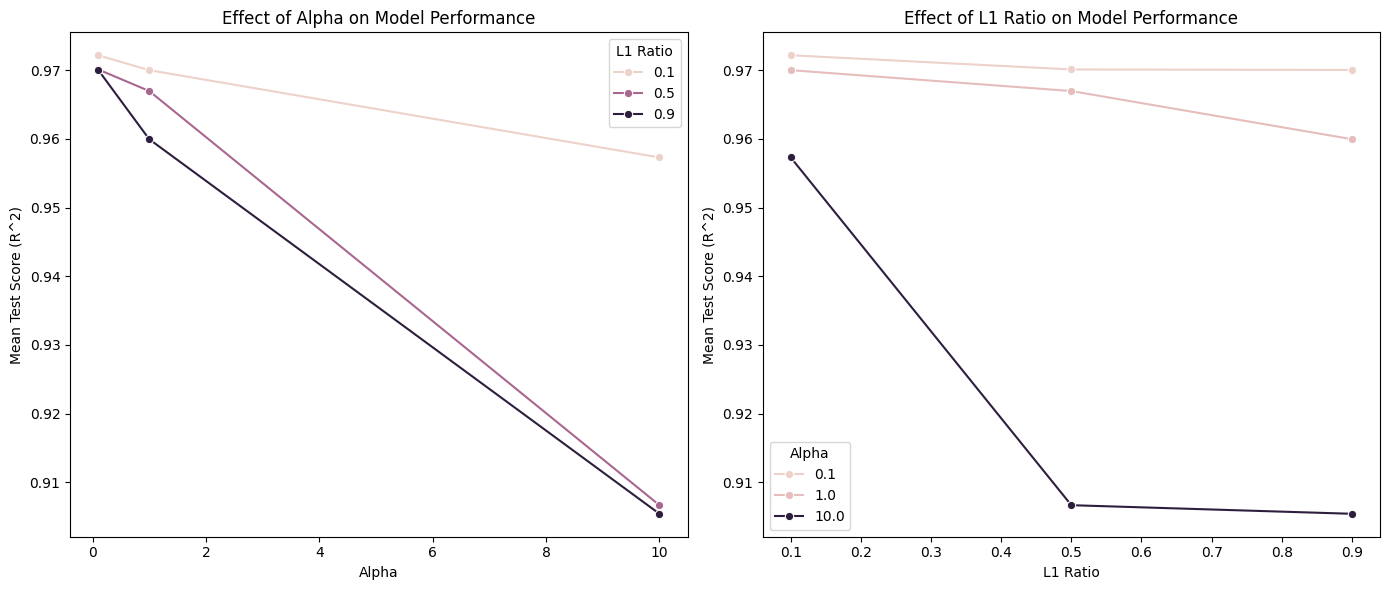

In [33]:
# Extract the results from the grid search
results = pd.DataFrame(grid_search.cv_results_)

# Plotting the effect of alpha on model performance
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.lineplot(x='param_alpha', y='mean_test_score', hue='param_l1_ratio', data=results, marker='o')
plt.xlabel('Alpha')
plt.ylabel('Mean Test Score (R^2)')
plt.title('Effect of Alpha on Model Performance')
plt.legend(title='L1 Ratio')

# Plotting the effect of l1_ratio on model performance
plt.subplot(1, 2, 2)
sns.lineplot(x='param_l1_ratio', y='mean_test_score', hue='param_alpha', data=results, marker='o')
plt.xlabel('L1 Ratio')
plt.ylabel('Mean Test Score (R^2)')
plt.title('Effect of L1 Ratio on Model Performance')
plt.legend(title='Alpha')

plt.tight_layout()
plt.show()


### Final Evaluation of the Bo Model
The final evaluation shows outstanding performance, with a training $R^2$ of **0.9740** and a test $R^2$ of **0.9783**. The visual crossplots for `logBo` are excellent. This model provides a validated, accurate method for determining Bo, which is essential for calculating Original Oil-In-Place (OOIP) and performing material balance calculations.

In [34]:
# Predict on the training and test sets
y_train_pred = grid_search.best_estimator_.predict(X_train)
y_test_pred = grid_search.best_estimator_.predict(X_test)

# Calculate performance metrics for training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate performance metrics for test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training Mean Squared Error: {train_mse:.4f}")
print(f"Training R^2 Score: {train_r2:.4f}")
print(f"Test Mean Squared Error: {test_mse:.4f}")
print(f"Test R^2 Score: {test_r2:.4f}")


Training Mean Squared Error: 0.0038
Training R^2 Score: 0.9740
Test Mean Squared Error: 0.0043
Test R^2 Score: 0.9783


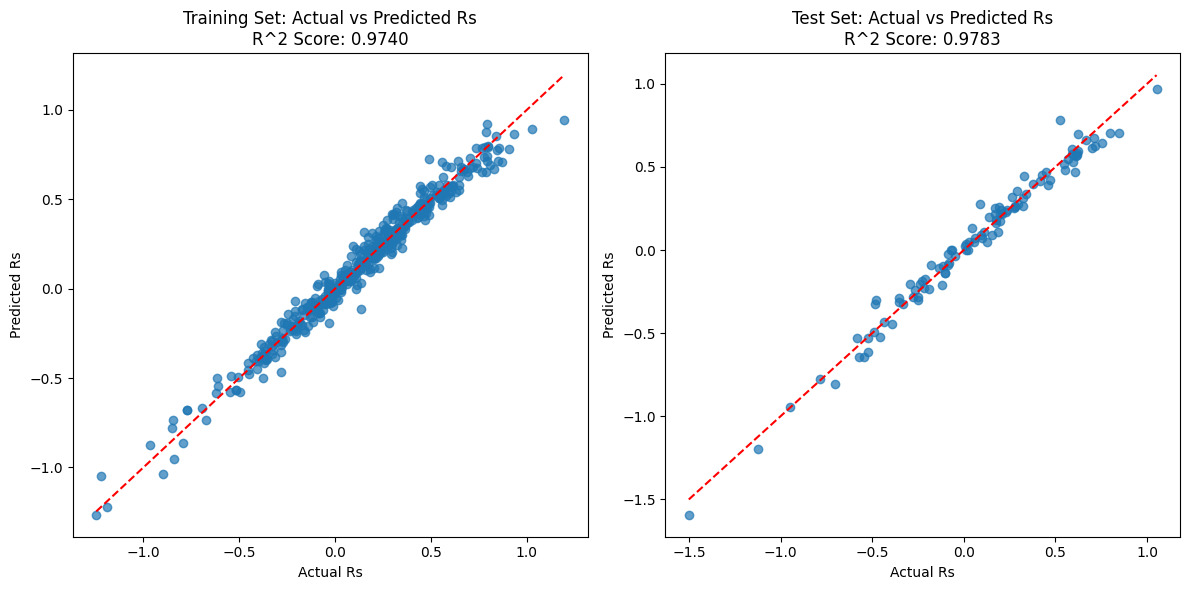

In [35]:
# Plot predicted vs actual for training set
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.7)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--r')
plt.xlabel('Actual Rs')
plt.ylabel('Predicted Rs')
plt.title(f'Training Set: Actual vs Predicted Rs\nR^2 Score: {train_r2:.4f}')

# Plot predicted vs actual for test set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual Rs')
plt.ylabel('Predicted Rs')
plt.title(f'Test Set: Actual vs Predicted Rs\nR^2 Score: {test_r2:.4f}')

plt.tight_layout()
plt.show()


#### Extract Mathematical Relationship

### Extracting the Bo Regression Equation
The final, trained model is converted into its explicit mathematical form. This equation provides a direct, quantitative relationship between the key compositional interaction terms and the logarithm of the oil formation volume factor. By taking the exponential of the result `(exp(logBo))`, this formula can be used to directly calculate 

In [36]:
model = grid_search.best_estimator_

# Retrieve the coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Display the coefficients and intercept
# print("Intercept:", intercept)
# print("Coefficients:", coefficients)

# Define your feature names
feature_names = df_top_10.columns.to_list() 

# Formulate the equation using the feature names
terms = [f"{coeff:.4f}*{name}" for coeff, name in zip(coefficients, feature_names)]
equation = " + ".join(terms)
equation = f"logBo = {intercept:.4f} + " + equation

print("Regression Equation:")
print(equation)
# Display the LaTeX-formatted equation in a Jupyter Notebook
from IPython.display import display, Math
display(Math(equation))

Regression Equation:
logBo = 1.1866 + -0.0003*C1 C7+ + 0.0064*C7+ + -0.0001*C7+^2 + -0.0000*C7+ MW + 0.0000*C7+ M7+ + -0.0006*C2 C7+ + -0.0030*nC5 C7+ + 0.0000*C1 + -0.0001*C1^2 + -0.0003*C3 C7+


<IPython.core.display.Math object>

### Finally

Lets clean up the equation now. remove those parts that have 0 as their coefficients.

$$
\log B_o = 1.1866
- 0.0003\,C_{1}C_{7_{+}}
+ 0.0064\,C_{7_{+}}
- 0.0001\,(C_{7_{+}})^2
- 0.0006\,C_{2}C_{7_{+}}
- 0.0030\,nC_{5}C_{7_{+}}
- 0.0001\,C_{1}^2
- 0.0003\,C_{3}C_{7_{+}}
$$


_**Author: Destiny Otto**_